# This will simulate:

A linear filter representing the receptive field

A stimulus matrix (e.g., oriented bar / Gabor contrast patterns)

A nonlinearity (e.g., exponential or rectified linear)

A Poisson spike generator

Parameter fitting via regression

Predict spikes using the LN model

In [2]:
import sys
import os

# Add project root to Python path
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

print(sys.path[:5])  # just to confirm

['/Users/carolinalangaro/miniforge3/lib/python312.zip', '/Users/carolinalangaro/miniforge3/lib/python3.12', '/Users/carolinalangaro/miniforge3/lib/python3.12/lib-dynload', '', '/Users/carolinalangaro/miniforge3/lib/python3.12/site-packages']


In [3]:
import numpy as np
import matplotlib.pyplot as plt

from src.utils import set_seed 
from src.simulate import simulate_spike_train

In [ ]:
def generate_grating_stimuli(orients, size=16, freq=3, phases=[0, np.pi/2]):
    """
    Generate sinusoidal gratings varying in orientation and phase.
    Returns (n_stimuli, size*size).
    """
    stimuli = []
    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    xx, yy = np.meshgrid(x, y)

    for theta in orients:
        rad = np.deg2rad(theta)
        xr = xx * np.cos(rad) + yy * np.sin(rad)

        for phase in phases:
            grating = np.cos(2 * np.pi * freq * xr + phase)
            stimuli.append(grating.flatten())
    
    return np.array(stimuli)


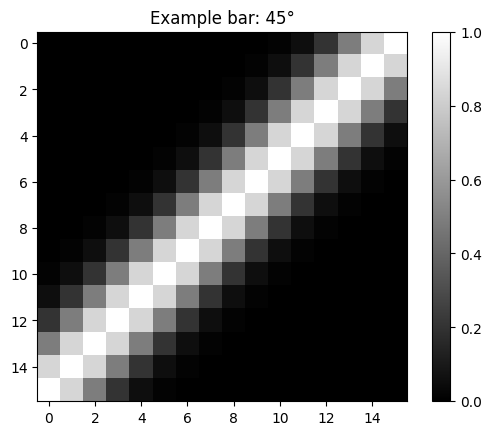

In [7]:
orients = np.linspace(0, 180, 8, endpoint=False)
stimuli = generate_bar_stimuli(orients)

plt.imshow(stimuli[2].reshape(16,16), cmap="gray")
plt.title(f"Example bar: {orients[2]:.0f}°")
plt.colorbar()


Create a true receptive field -- simulate a V1-like gabor filter

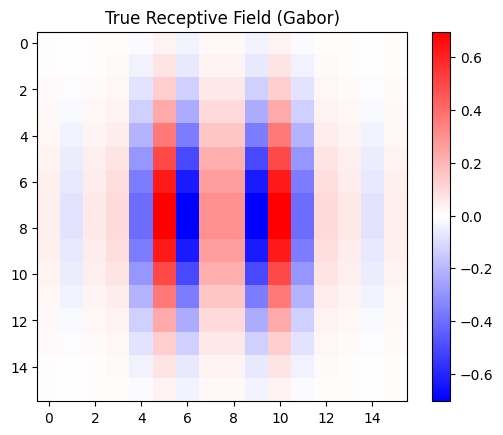

In [8]:
def gabor_filter(size=16, freq=3, theta=90, sigma=0.4):
    x = np.linspace(-1, 1, size)
    y = np.linspace(-1, 1, size)
    xx, yy = np.meshgrid(x, y)

    rad = np.deg2rad(theta)
    xr = xx * np.cos(rad) + yy * np.sin(rad)
    yr = -xx * np.sin(rad) + yy * np.cos(rad)

    gabor = np.exp(-(xr**2 + yr**2) / (2 * sigma**2)) * np.cos(2 * np.pi * freq * yr)
    return gabor.flatten()

true_filter = gabor_filter(theta=90)

plt.imshow(true_filter.reshape(16,16), cmap="bwr")
plt.title("True Receptive Field (Gabor)")
plt.colorbar()


Centered Gaussian envelope

Response strongest near the centre
Fades to white toward edges
This shows the Gaussian envelope, which localizes the receptive field

All of this is what a classic V1 simple cell receptive field looks like.

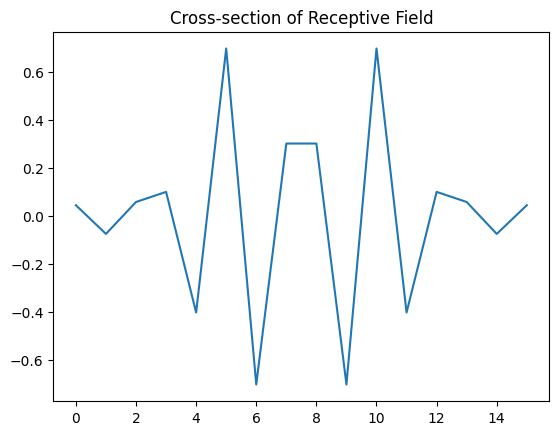

In [ ]:
plt.plot(true_filter.reshape(16,16)[8,:])
plt.title("Cross-section of Receptive Field")
plt.show()

# reveal sinusoidal structure around centre


In [10]:
linear_response = stimuli @ true_filter


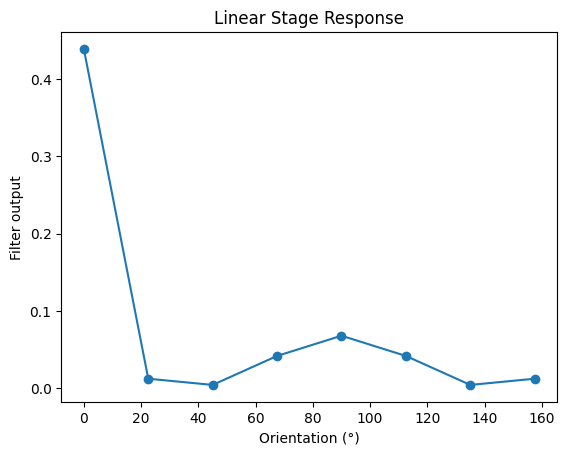

In [11]:
plt.plot(orients, linear_response, "o-")
plt.title("Linear Stage Response")
plt.xlabel("Orientation (°)")
plt.ylabel("Filter output")
plt.show()


In [12]:
def nonlinearity(x):
    return np.exp(x)

rates = nonlinearity(linear_response)


In [ ]:
rates_norm = (rates - np.min(rates)) / (np.max(rates) - np.min(rates))
rates = 5 + 25 * rates_norm


In [13]:
set_seed(0)
duration = 1.0
dt = 0.001

spike_trains = [
    simulate_spike_train(r, duration, dt)
    for r in rates
]

firing_rates = np.array([len(tr) / duration for tr in spike_trains])


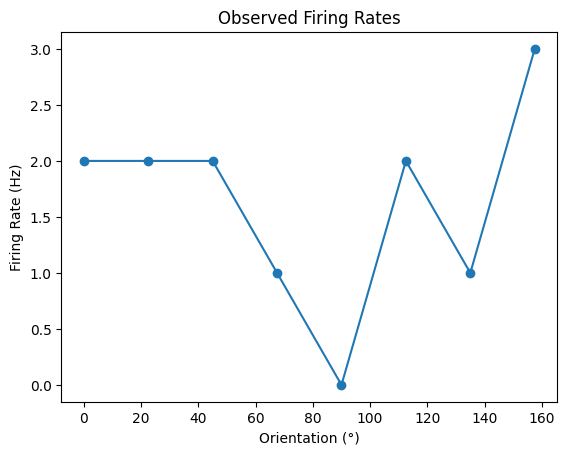

In [14]:
plt.plot(orients, firing_rates, "o-")
plt.title("Observed Firing Rates")
plt.xlabel("Orientation (°)")
plt.ylabel("Firing Rate (Hz)")
plt.show()


In [15]:
from sklearn.linear_model import LinearRegression

# log-transform firing rate to invert the exponential
y = np.log(firing_rates + 1e-8)

reg = LinearRegression()
reg.fit(stimuli, y)

estimated_filter = reg.coef_


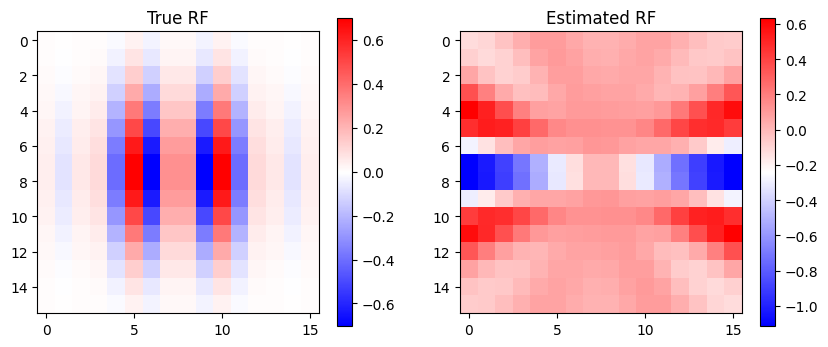

In [16]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(true_filter.reshape(16,16), cmap="bwr")
plt.title("True RF")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(estimated_filter.reshape(16,16), cmap="bwr")
plt.title("Estimated RF")
plt.colorbar()

plt.show()


In [17]:
pred_linear = stimuli @ estimated_filter
pred_rates = np.exp(pred_linear)
pred_rates = 5 + 25 * (pred_rates / np.max(pred_rates))


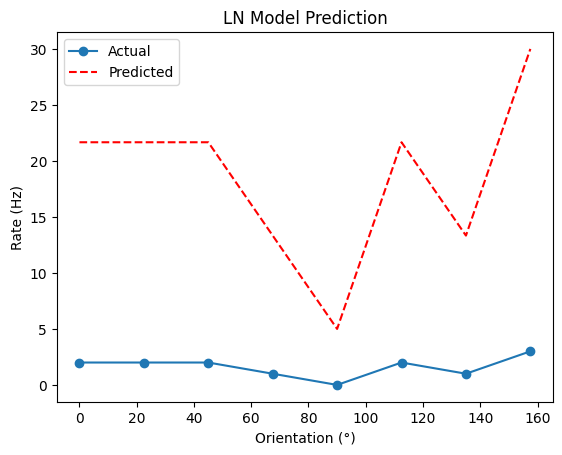

In [18]:
plt.plot(orients, firing_rates, "o-", label="Actual")
plt.plot(orients, pred_rates, "r--", label="Predicted")
plt.xlabel("Orientation (°)")
plt.ylabel("Rate (Hz)")
plt.title("LN Model Prediction")
plt.legend()
plt.show()
